In [17]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import make_scorer, confusion_matrix, recall_score, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
import scikitplot as skp

In [2]:
cd /Users/Jeremy/GoogleDrive/Data_Science/Projects/Education_Data/harvard_ed_x

/Users/Jeremy/GoogleDrive/Data_Science/Projects/Education_Data/harvard_ed_x


In [3]:
from src.train_model import DropCols, ScaleSubset, standard_confusion_matrix, print_roc_curve

/Users/Jeremy/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred, labels=[0,1])
    return np.array([[tp, fp], [fn, tn]])

def print_roc_curve(y_test, probabilities, model_name, roc_auc, recall):
    '''
    Calculates and prints a ROC curve given a set of test classes and probabilities from a trained classifier
    
    Parameters:
    ----------
    y_test: 1d array
    probabilities: 1d array of predeicted probabilites from X_test data
    model_name: name of model, for printing plot label
    recall: model recall score
    '''
    tprs, fprs, thresh = roc_curve(y_test, probabilities)
    plt.figure(figsize=(12,10))
    plt.plot(fprs, tprs, 
         label="AUC: {}\nRecall {}".format(round(roc_auc, 3), round(recall, 3)),
         color='blue', 
         lw=3)
    plt.plot([0,1],[0,1], 'k:')
    plt.legend(loc = 4, prop={'size': 45})
    plt.xlabel("FPR", fontsize=20)
    plt.ylabel("TPR", fontsize=20)
    plt.title("ROC Curve: {}".format(model_name), fontsize=40)
    
def print_confusion_matrix(conf_mat, model_name):
    '''
    Prints a formatted confusion matrix as a Seaborn heatmap with appropriate labels and titles.
    
    Parameters:
    ----------
    conf_mat: sklearn confusion matrix of classifier output
    model_name: name of model, for printing plot label
    
    '''
    plt.figure(figsize=(10,6))
    sns.heatmap(conf_mat, annot=conf_mat, cmap='coolwarm_r', fmt='d', annot_kws={"size": 40})
    plt.xlabel('Predicted Pass        Predicted Fail', fontsize=25)
    plt.ylabel('Actual Fail      Actual Pass', fontsize=25)
    plt.title('{} Confusion Matrix'.format(model_name), fontsize=40)

def plot_target_hist(feature, h_range, bins=50, alpha=0.8):
    '''
    Plot a histogram of a feature with color indicating model prediction.
    
    feature: model feature as represented by a column in a dataframe
    h_range: range of values to print based on feature
    
    '''
    pos = np.where(y_test == True)
    neg = np.where(y_test == False)
    plt.figure(figsize=(12,8))
    plt.hist(X_test.loc[pos][feature], range=h_range, bins=bins, alpha=alpha, label='Fail')
    plt.hist(X_test.loc[neg][feature], range=h_range, bins=bins, alpha=alpha, label='Pass')
    plt.legend(prop={'size': 30})
    plt.title(feature, fontsize=30)

def plot_target_violin(df, feature):
    '''
    Plot a violin plt of a feature with color indicating model prediction.
    
    feature: model feature as represented by a column in a dataframe
    
    '''
    df1 = df.copy()
    df1['Predict Pass'] = y_test*-1+1
    plt.figure(figsize=(12,8))
    sns.violinplot(x = 'Predict Pass', y=feature, data=df1)
    plt.title(feature, fontsize=30)

def compare_hist(df1, df2, l1, l2):
    '''
    Prints overlayed histograms for comparison of distributions in two dataframes.
    
    Parameters:
    ----------
    df1: Pandas dataframe
    df2: Pandas dataframe with exact same columns as df1
    '''

    for col in df1.columns:
        plt.figure(figsize=(12,10))
        plt.hist(df1[col], bins=30, label=l1, alpha=0.6)
        plt.hist(df2[col], bins=30, label=l2, alpha=0.6)
        plt.legend()
        plt.title(col)
        plt.show()

In [5]:
model = pickle.load(open("models/gb_model.p", "rb"))

In [6]:
X_test = pd.read_csv("data/X_test.csv")
y_test = pd.read_csv("data/y_test.csv")
# X_train = pd.read_csv("data/X_train.csv")
# y_train = pd.read_csv("data/y_train.csv")

In [9]:
    t = 0.5 # threshold for predicting positive    
    predictions = (model.predict_proba(X_test)[:, 1:] > t)
    roc_auc = roc_auc_score(y_test, predictions)
    probas = model.predict_proba(X_test)[:, :1]
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions, average='binary')
    conf_mat = confusion_matrix(y_test, predictions, labels=None) # sklearn way
    class_report = classification_report(y_test, predictions)


Classification Report:
              precision    recall  f1-score   support

          0       0.99      0.99      0.99    110550
          1       0.76      0.78      0.77      4713

avg / total       0.98      0.98      0.98    115263



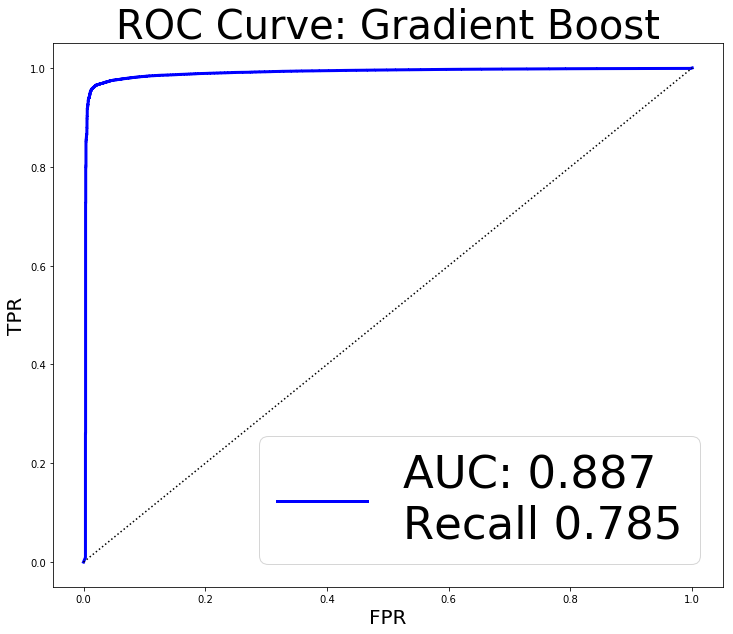

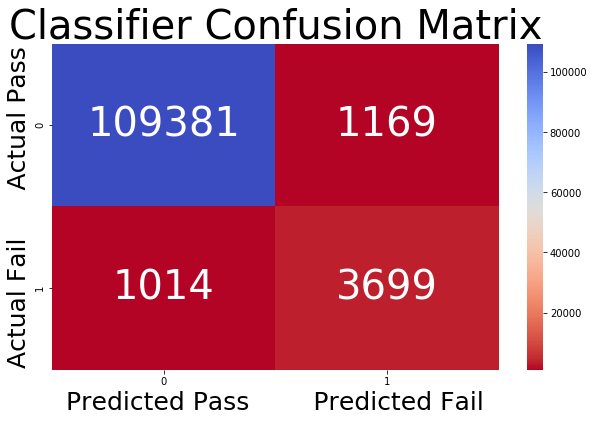

In [10]:
    print_roc_curve(y_test, probas, "Gradient Boost", roc_auc, recall)
#     plt.savefig('../reports/figures/rf_roc.png')
    print_confusion_matrix(conf_mat, 'Classifier')
#     plt.savefig('../reports/figures/rf_conf_mat.png')
    print('\nClassification Report:\n {}'.format(class_report))

In [11]:
X_test.columns

Index(['course_id', 'userid_DI', 'viewed', 'explored', 'YoB', 'grade',
       'start_time_DI', 'last_event_DI', 'nevents', 'ndays_act', 'nplay_video',
       'nchapters', 'nforum_posts', 'YoB_imputed', 'nplay_video_imputed',
       'nchapters_imputed', 'LoE_DI_imputed', 'gender_imputed',
       'grade_imputed', 'australia', 'bangladesh', 'brazil', 'canada', 'china',
       'colombia', 'egypt', 'france', 'germany', 'greece', 'india',
       'indonesia', 'japan', 'mexico', 'morocco', 'nigeria', 'otherafrica',
       'othereastasia', 'othereurope', 'othermiddleeast/centralasia',
       'othernorth&centralamer.,caribbean', 'otheroceania',
       'othersouthamerica', 'othersouthasia', 'pakistan', 'philippines',
       'poland', 'portugal', 'russianfederation', 'spain', 'ukraine',
       'unitedkingdom', 'unitedstates', '1988.0_x', 'bachelor's', 'doctorate',
       'lessthansecondary', 'master's', '1988.0_y', 'f', 'm'],
      dtype='object')

In [13]:
plot_partial_dependence(model, X_test, X_test.columns)

ValueError: gbrt has to be an instance of BaseGradientBoosting

<Figure size 432x288 with 0 Axes>

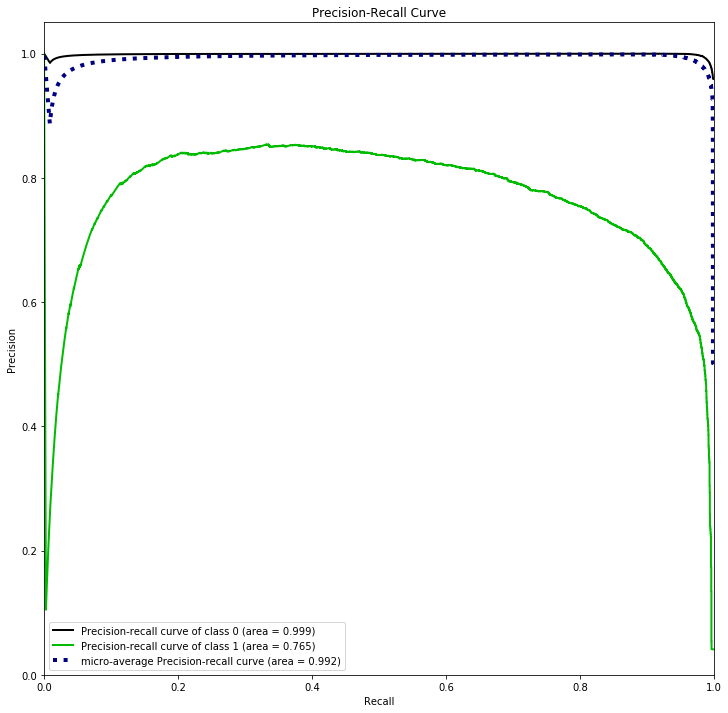

In [21]:
skp.metrics.plot_precision_recall(y_test, model.predict_proba(X_test),figsize=(12,12))

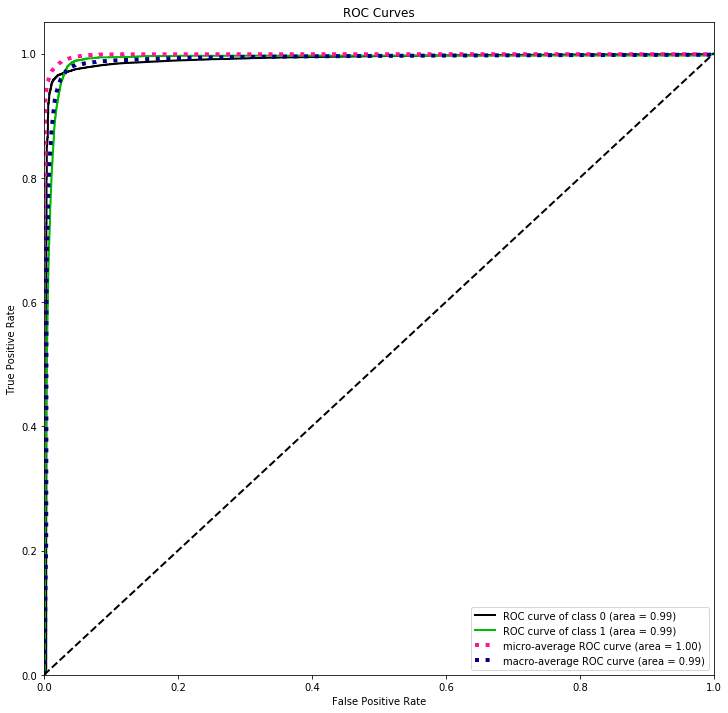

In [22]:
skp.metrics.plot_roc(y_test, model.predict_proba(X_test),figsize=(12,12))

In [23]:
model.

0.7758909687516932